# **Data Pre-Processing**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.pandas.set_option("display.max_columns", 100)
# Create Dataframe
df = pd.read_csv('data/marketing_campaign.csv')
# Print shape of dataset
print(df.shape)

(2240, 29)


In [5]:
# Check for null values

##these are the features with nan value
features_with_na=[features for features in df.columns if df[features].isnull().sum()>=1]
for feature in features_with_na:
    print(feature,np.round(df[feature].isnull().mean()*100,5), '% missing values')

Income 1.07143 % missing values


In [6]:
# statistics on numerical columns (Null cols)
df[features_with_na].select_dtypes(exclude='object').describe()

Income
count    2216.000000
mean    52247.251354
std     25173.076661
min      1730.000000
25%     35303.000000
50%     51381.500000
75%     68522.000000
max    666666.000000

In [8]:
#Age
df.Income.fillna(df.Income.median(), inplace=True)

### Handling duplicates

In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
columns_to_drop = ['ID', 'Z_CostContact','Z_Revenue']
df.drop(columns = columns_to_drop, inplace=True)

# **Feature Engineering**

### Some Steps will repeat from EDA

In [13]:
# create new column for feature

from datetime import datetime


df = df.copy()

##  creating a new field to store the Age of the customer
df['Age']=2022-df['Year_Birth']   

###  recoding the customer's education level to numeric form (0: high-school, 1: diploma, 2: bachelors, 3: masters, and 4: doctorates)
df["Education"].replace({"Basic":0,"2n Cycle":1, "Graduation":2, "Master":3, "PhD":4},inplace=True)  

#  recoding the customer's marital status to numeric form (0: not living with a partner, 1: living with a partner) 
df['Marital_Status'].replace({"Married":1, "Together":1, "Absurd":0, "Widow":0, "YOLO":0, "Divorced":0, "Single":0,"Alone":0},inplace=True) 

#  creating a new field to store the number of children in the household
df['Children']=df['Kidhome']+df['Teenhome']

#creating Family_Size
df['Family_Size']=df['Marital_Status']+df['Children']+1



#  creating a new field to store the total spending of the customer
df['Total_Spending']=df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]
df["Total Promo"] =  df["AcceptedCmp1"]+ df["AcceptedCmp2"]+ df["AcceptedCmp3"]+ df["AcceptedCmp4"]+ df["AcceptedCmp5"]

## The following code works out how long the customer has been with the company and store the total number of promotions the customers responded to
# dates in the dataset are day-first (e.g. '21-08-2013'), so use dayfirst=True;
# errors='coerce' ensures malformed entries don't raise an exception
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], dayfirst=True, errors='coerce')

# If any parsing failed, drop those rows (or handle them as needed)
if df['Dt_Customer'].isnull().any():
    n_null = df['Dt_Customer'].isnull().sum()
    warnings.warn(f"{n_null} Dt_Customer entries couldn't be parsed and were set to NaT; dropping those rows.")
    df = df[df['Dt_Customer'].notna()].copy()

today = datetime.today()
df['Days_as_Customer'] = (today - df['Dt_Customer']).dt.days
df['Offers_Responded_To'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['Response']
df["Parental Status"] = np.where(df["Children"] > 0, 1, 0)






#dropping columns which are already used to create new features
columns_to_drop = ['Year_Birth','Kidhome','Teenhome']
df.drop(columns = columns_to_drop, axis = 1, inplace=True)
df.rename(columns={"Marital_Status": "Marital Status","MntWines": "Wines","MntFruits":"Fruits",
                   "MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets",
                   "MntGoldProds":"Gold","NumWebPurchases": "Web","NumCatalogPurchases":"Catalog",
                   "NumStorePurchases":"Store","NumDealsPurchases":"Discount Purchases"},
          inplace = True)

df = df[["Age","Education","Marital Status","Parental Status","Children","Income","Total_Spending","Days_as_Customer","Recency","Wines","Fruits","Meat","Fish","Sweets","Gold","Web","Catalog","Store","Discount Purchases","Total Promo","NumWebVisitsMonth"]]

In [15]:
#Type of Features

#Numeric
num_features = df.select_dtypes(include='number').columns.to_list()
print('Num of Numerical Features :', len(num_features))

cat_features = df.select_dtypes(include='object').columns.to_list()
print('Num of Categorical Features :', len(cat_features))

Num of Numerical Features : 21
Num of Categorical Features : 0


In [16]:
discrete_features=[feature for feature in num_features if len(df[feature].unique())<=25]
print('Num of Discrete Features :',len(discrete_features))

Num of Discrete Features : 10


In [17]:
continuous_features=[feature for feature in num_features if feature not in discrete_features]
print('Num of Continuous Features :',len(continuous_features))

Num of Continuous Features : 11


### Outlier Treatment

In [18]:
continuous_features

['Age',
 'Income',
 'Total_Spending',
 'Days_as_Customer',
 'Recency',
 'Wines',
 'Fruits',
 'Meat',
 'Fish',
 'Sweets',
 'Gold']

### Outlier Detection

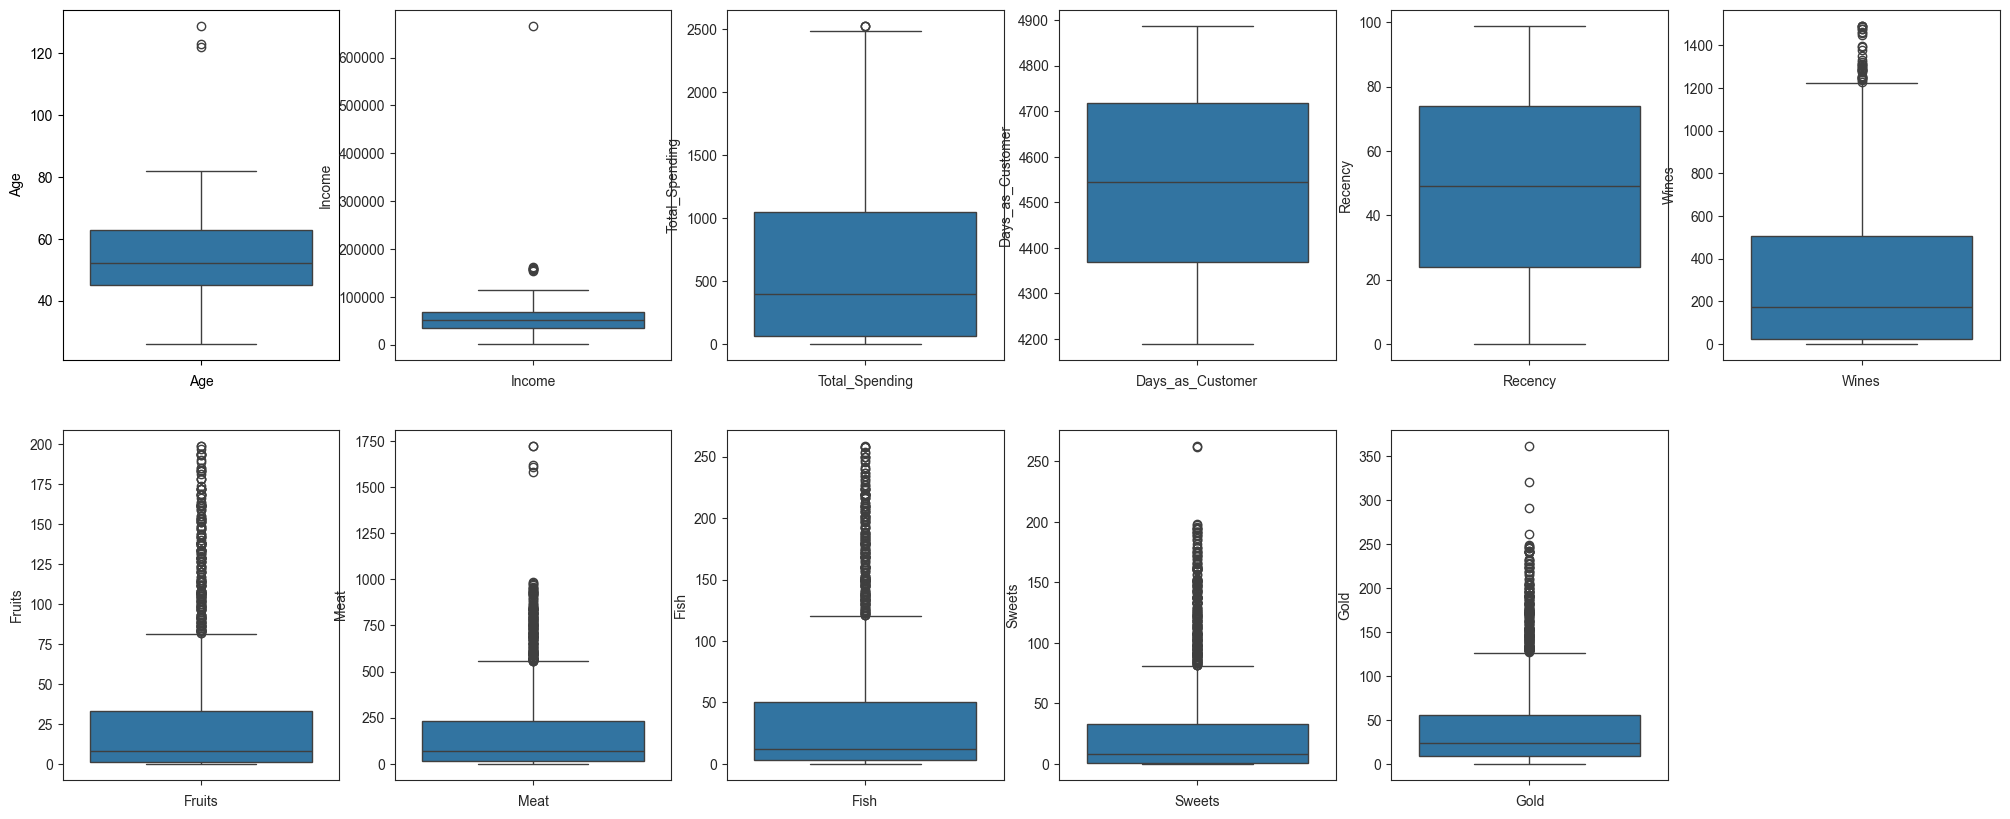

In [19]:
cont_features = continuous_features.copy()
plt.figure(figsize=(25, 10))

for i in range(len(cont_features)):
        plt.subplot(2,6,i+1)
        sns.set_style('ticks')
        plt.xlabel(cont_features[i])
        ax = sns.boxplot(df[cont_features[i]])

### Detecting Outlier and Capping it

In [21]:
def detect_outliers(col):
    # Finding the IQR
    percentile25 = df[col].quantile(0.25)
    percentile75 = df[col].quantile(0.75)
    print('\n ####', col , '####')
    print("percentile25",percentile25)
    print("percentile75",percentile75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    print("Upper limit",upper_limit)
    print("Lower limit",lower_limit)
    df.loc[(df[col]>upper_limit), col]= upper_limit
    df.loc[(df[col]<lower_limit), col]= lower_limit    
    return df

### Why are we capping it and why not trim it ?

- Trimming outliers may result in the removal of a large number of records from this dataset as we have already very less rows so this isn’t desirable in this case since columns other than the ones containing the outlier values may contain useful information.

- In this cases, you can use outlier capping to replace the outlier values with a maximum or minimum capped values. Be warned, this manipulates our data but we can replace outlier values by the upper and lower limit calculated using the IQR range.

In [23]:
for col in continuous_features:
        detect_outliers(col)


 #### Age ####
percentile25 45.0
percentile75 63.0
Upper limit 90.0
Lower limit 18.0

 #### Income ####
percentile25 35538.75
percentile75 68289.75
Upper limit 117416.25
Lower limit -13587.75

 #### Total_Spending ####
percentile25 68.75
percentile75 1045.5
Upper limit 2510.625
Lower limit -1396.375

 #### Days_as_Customer ####
percentile25 4369.75
percentile75 4718.0
Upper limit 5240.375
Lower limit 3847.375

 #### Recency ####
percentile25 24.0
percentile75 74.0
Upper limit 149.0
Lower limit -51.0

 #### Wines ####
percentile25 23.75
percentile75 504.25
Upper limit 1225.0
Lower limit -697.0

 #### Fruits ####
percentile25 1.0
percentile75 33.0
Upper limit 81.0
Lower limit -47.0

 #### Meat ####
percentile25 16.0
percentile75 232.0
Upper limit 556.0
Lower limit -308.0

 #### Fish ####
percentile25 3.0
percentile75 50.0
Upper limit 120.5
Lower limit -67.5

 #### Sweets ####
percentile25 1.0
percentile75 33.0
Upper limit 81.0
Lower limit -47.0

 #### Gold ####
percentile25 9.0
percenti

### Checkung Skewness after Outlier Capping

In [24]:
df[continuous_features].skew(axis=0, skipna=True)

Age                 0.120199
Income              0.090027
Total_Spending      0.860245
Days_as_Customer   -0.015216
Recency            -0.001987
Wines               1.096611
Fruits              1.233953
Meat                1.213585
Fish                1.230822
Sweets              1.213346
Gold                1.111307
dtype: float64

### **Feature Transformation**
## Scaling
#### What is Feature Scaling
- Feature scaling is a method used to normalize the range of independent variables or features of data. In data processing, it is also known as data normalization and is generally performed during the data preprocessing step.
- Why we use feature scaling?
the feature scaling was implemented to prevent any skewness in the contour plot of the cost function which affects the gradient descent but the analytical solution using normal equation does not suffer from the same drawback.

In [25]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
outlier_features = ["Wines","Fruits","Meat","Fish","Sweets","Gold","Age","Total_Spending"] #we can find the columns which has oitliers in the EDA
numeric_features = [x for x in numeric_features if x not in outlier_features]

In [26]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


dataC = df.copy()

numeric_pipeline = Pipeline(steps=
                            [("Imputer", SimpleImputer(strategy='constant', fill_value=0)), 
                             ("StandardScaler", StandardScaler())]
                           )

outlier_features_pipeline = Pipeline(steps=
                                     [("Imputer", SimpleImputer(strategy='constant', fill_value=0)),
                                      ("transformer", PowerTransformer(standardize=True))]
                                    )

preprocessor = ColumnTransformer(
    [
        ("numeric pipeline",numeric_pipeline, numeric_features),
        ("Outliers Features Pipeline", outlier_features_pipeline, outlier_features)
    ]
)

columns = dataC.columns
dataC = preprocessor.fit_transform(dataC)
scaled_data = pd.DataFrame(dataC, columns= columns )
print("After scaling, let's have a glimpse of the scaled dataset :")
scaled_data.head()

After scaling, let's have a glimpse of the scaled dataset :


Age  Education  Marital Status  Parental Status  Children    Income  \
0 -0.458383  -1.346874       -1.584605        -1.264505  0.299651  1.531185   
1 -0.458383  -1.346874        0.631072         1.396361 -0.263808 -1.190545   
2 -0.458383   0.742460       -1.584605        -1.264505  0.943420 -0.205773   
3 -0.458383   0.742460        0.631072         0.065928 -1.204881 -1.061881   
4  1.533425   0.742460        0.631072         0.065928  0.307056 -0.953012   

   Total_Spending  Days_as_Customer   Recency     Wines    Fruits      Meat  \
0        0.307039          1.409304  2.510890 -0.550785  0.349414 -0.439037   
1       -0.383664         -1.110409 -0.568720 -1.166125 -0.168236 -0.439037   
2       -0.798086          1.409304 -0.226541  1.295237 -0.685887 -0.439037   
3       -0.798086         -0.750450 -0.910898 -0.550785 -0.168236 -0.439037   
4        1.550305          0.329427  0.115638  0.064556  1.384715 -0.439037   

       Fish    Sweets      Gold       Web   Catalog     Store  \
0  0.693904  1.062784  1.487681  1.504406  1.493989  1.474200   
1 -0.130463 -1.211545 -1.001121 -1.376502 -0.889143 -0.987648   
2 -0.542647  0.748918  1.145877  0.456428  1.435812  0.579704   
3  0.281720 -1.211545 -0.403311 -0.722233 -0.110828 -0.542753   
4 -0.130463  0.123712  1.058075  0.406278  0.832291  0.741799   

   Discount Purchases  Total Promo  NumWebVisitsMonth  
0            1.196801     1.005341           1.315365  
1           -0.967034     1.239521          -1.441417  
2            0.473642     0.361223           0.661170  
3           -1.069040    -1.315014          -1.117211  
4           -0.368949    -1.033428           0.179322

# **Model Building ( Clustering )**

### We know that our dataset it unsupervised, that means we don't have such target column. So we will be using clustering algorithms first to cluster the dataset and create target levels out of it.

# Create a function for Silhouette score plot
## What is silhouette score
- The silhouette value is a measure of how similar an object is to its o**wn cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

In [27]:
# this function we take it from sklearn page for ploting silhouette with little Modification 
#ploting silhouette_plot aside with clustring results in PCA
from sklearn.metrics import silhouette_score,silhouette_samples
from matplotlib import cm

def silhouette_plot(model,range_n_clusters,X_clustering,pca,**kwargs):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X_clustering) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = model(n_clusters,**kwargs)
        cluster_labels = clusterer.fit_predict(X_clustering)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X_clustering, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X_clustering, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.2,-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
    #     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

        sns.scatterplot(
            x = pca[:, 0],
            y = pca[:, 1],
            hue=cluster_labels,
            palette=sns.color_palette("colorblind", len(set(cluster_labels))),
            alpha=0.7,
            legend="full",
            ax = ax2
        )
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            f"Silhouette analysis for {model.__name__} clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

## **PCA (Principal Component Analysis)**
- There is many high correlation feature so we will use some dimentinality reduction. We can use PCA

- Principal Component Analysis, or PCA, is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.

- Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity. Because smaller data sets are easier to explore and visualize and make analyzing data much easier and faster for machine learning algorithms without extraneous variables to process.

In [28]:
#Applying PCA
from sklearn.decomposition import PCA
df_scaled = scaled_data.copy()
var_ratio={}
for n in range(2,18):
    pc=PCA(n_components=n)
    df_pca=pc.fit(df_scaled)
    var_ratio[n]=sum(df_pca.explained_variance_ratio_)

In [29]:
# apply PCA and display clustering metrics
from sklearn.cluster import KMeans
for y in range(2, 8):
    print("PCA with # of components: ", y)
    pca = PCA(n_components=y)
    data_p = pca.fit_transform(df_scaled)
    for x in range(2, 7):
        kmeans = KMeans(n_clusters = x,)
        label = kmeans.fit_predict(data_p)
        print('Silhouette-Score for', x,  'Clusters: ', silhouette_score(data_p, label) , '-  Inertia: ',kmeans.inertia_)
    print()

PCA with # of components:  2
Silhouette-Score for 2 Clusters:  0.5284351276031598 -  Inertia:  9059.717502690131
Silhouette-Score for 3 Clusters:  0.5102088250272875 -  Inertia:  5130.341121015592
Silhouette-Score for 4 Clusters:  0.45575685612335537 -  Inertia:  3982.921157259704
Silhouette-Score for 5 Clusters:  0.44891268584137467 -  Inertia:  3304.293602145154
Silhouette-Score for 6 Clusters:  0.39477903438205636 -  Inertia:  2835.9719994005136

PCA with # of components:  3
Silhouette-Score for 2 Clusters:  0.45452039996183863 -  Inertia:  12743.738453626267
Silhouette-Score for 3 Clusters:  0.40649011339719776 -  Inertia:  8794.90786807269
Silhouette-Score for 4 Clusters:  0.34045132091551633 -  Inertia:  7600.414647210039
Silhouette-Score for 5 Clusters:  0.3147232885114219 -  Inertia:  6300.939268136124
Silhouette-Score for 6 Clusters:  0.31092669949334256 -  Inertia:  5707.839836717873

PCA with # of components:  4
Silhouette-Score for 2 Clusters:  0.4174324110950721 -  Inertia

- We can go with PCA with 2 components.
- We can go with Kmeans Clusters in the range of 4-6 as it has Good score with lesser Inertia compared to others

In [30]:
# Reducing the dimensions of the data 
pca_final=PCA(n_components=2,random_state=42).fit(df_scaled)

reduced=pca_final.fit_transform(df_scaled)
pcadf = pd.DataFrame(reduced) 
pcadf.columns = ['PC1', 'PC2'] 
  
pcadf.head(10)

PC1       PC2
0  4.130751  0.501059
1 -3.495848 -0.524323
2  3.032352 -0.850799
3 -2.794852 -1.108400
4  0.786683  0.794184
5  1.105611  0.968065
6  1.539503  1.352260
7 -1.842628  0.488612
8 -3.457028 -0.155012
9 -5.229958  1.478703

In [31]:
pca_final.explained_variance_ratio_

array([0.39488178, 0.10833485])

## Elbow Method

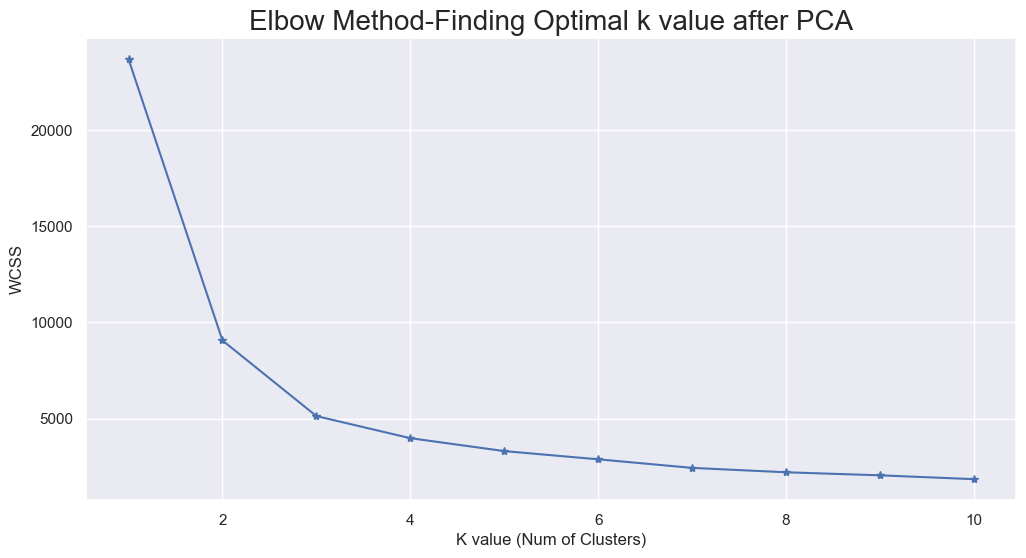

In [32]:
wcss= {}
sns.set()
plt.figure(figsize=(12,6))
for i in range(1,11): 
    km = KMeans(n_clusters=i)
    km.fit(pcadf)
    wcss[i]=km.inertia_

plt.plot(range(1,11),wcss.values(), marker='*')
plt.title('Elbow Method-Finding Optimal k value after PCA', fontsize =20)
plt.xlabel('K value (Num of Clusters)')
plt.ylabel('WCSS')
plt.show()

# K = 3

For n_clusters = 3 The average silhouette_score is : 0.5103338817304216
For n_clusters = 4 The average silhouette_score is : 0.45277333703737105
For n_clusters = 5 The average silhouette_score is : 0.44891268584137467
For n_clusters = 6 The average silhouette_score is : 0.3853518095290996


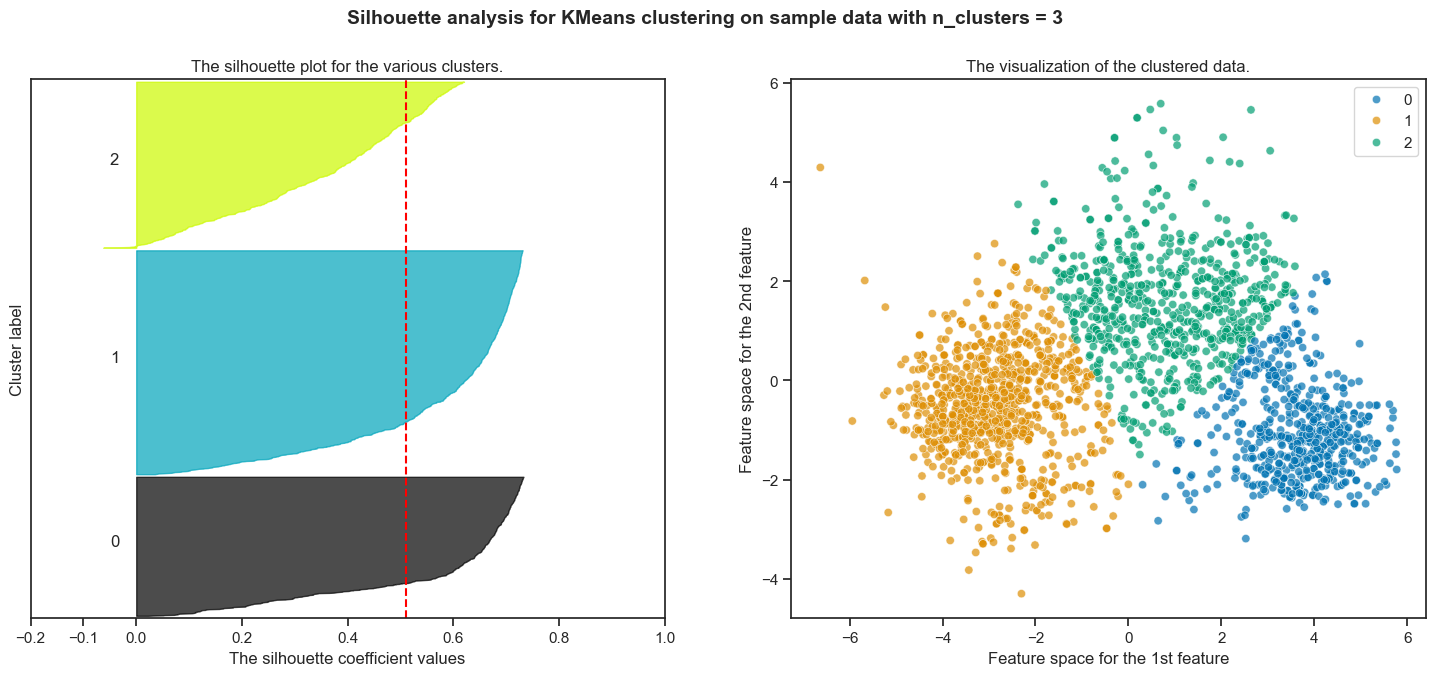

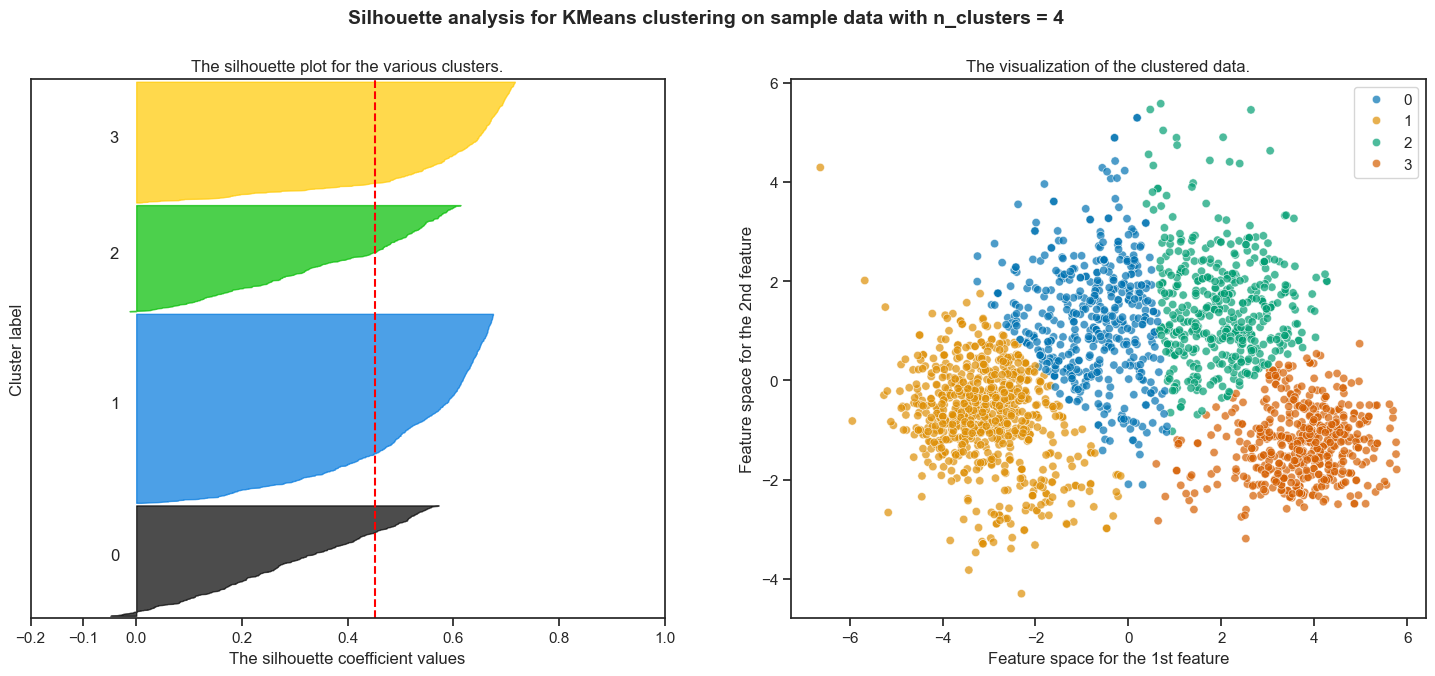

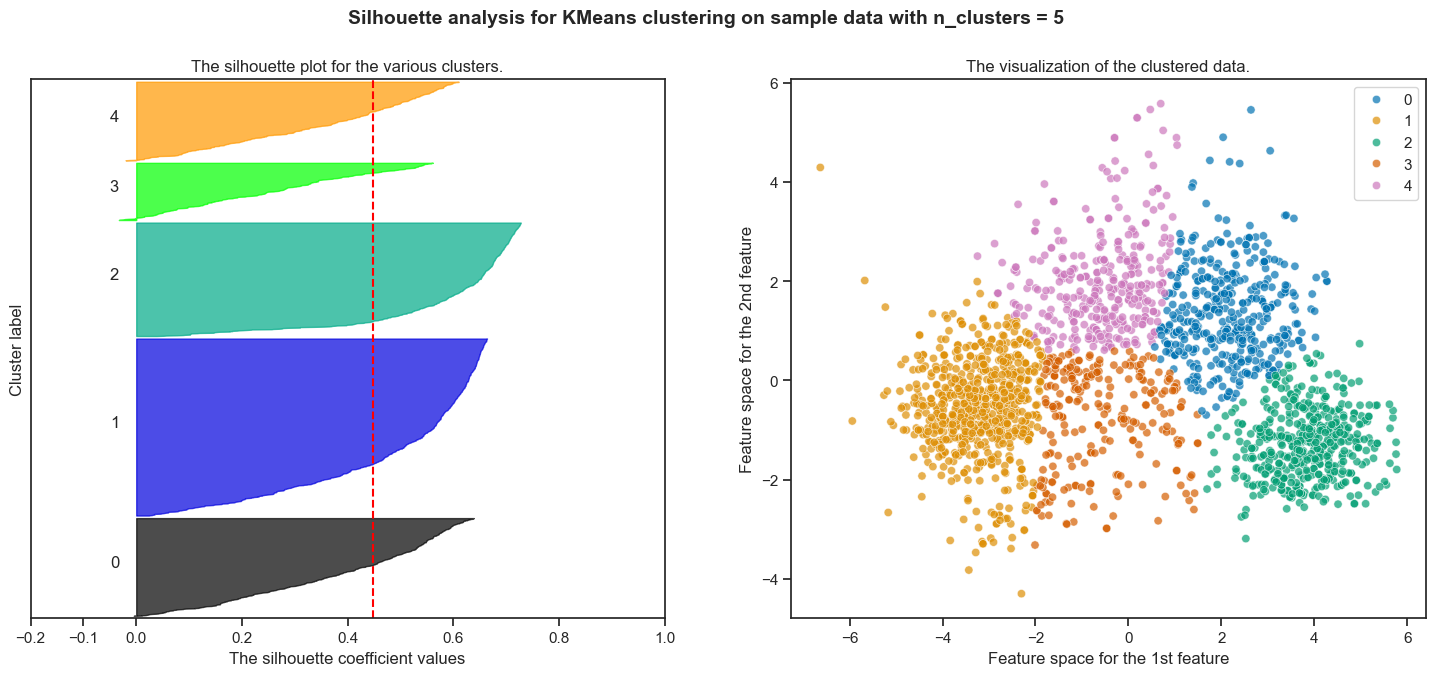

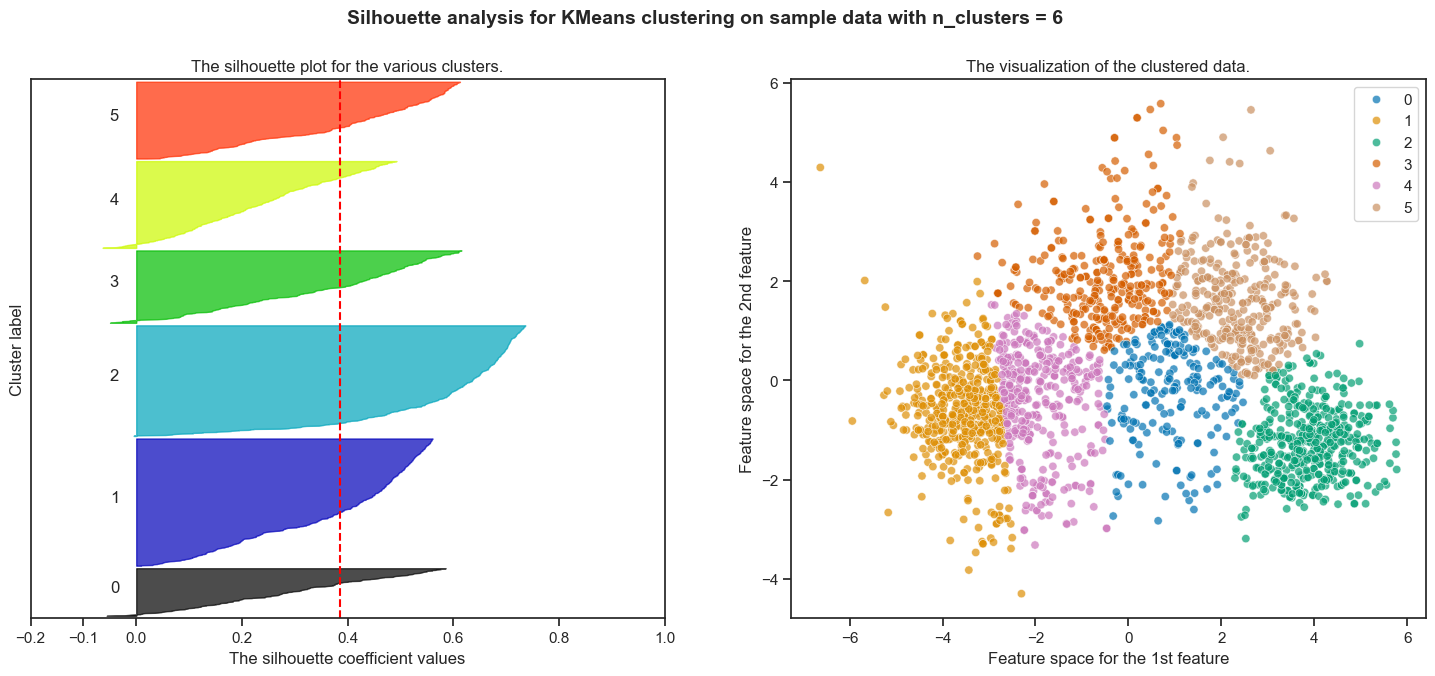

In [33]:
# We plot silhoutte score for Kmeans
# Here pcadf is pca dataframe, and Reduced is array of data after PCA.
sns.set_style('ticks')
silhouette_plot(KMeans,range(3,7), pcadf, reduced)

### Apply K means using k = 3

In [34]:
# Fitting the model to reduced data
model = KMeans(n_clusters=3).fit(pcadf)
model_label = model.labels_
model_centers = model.cluster_centers_

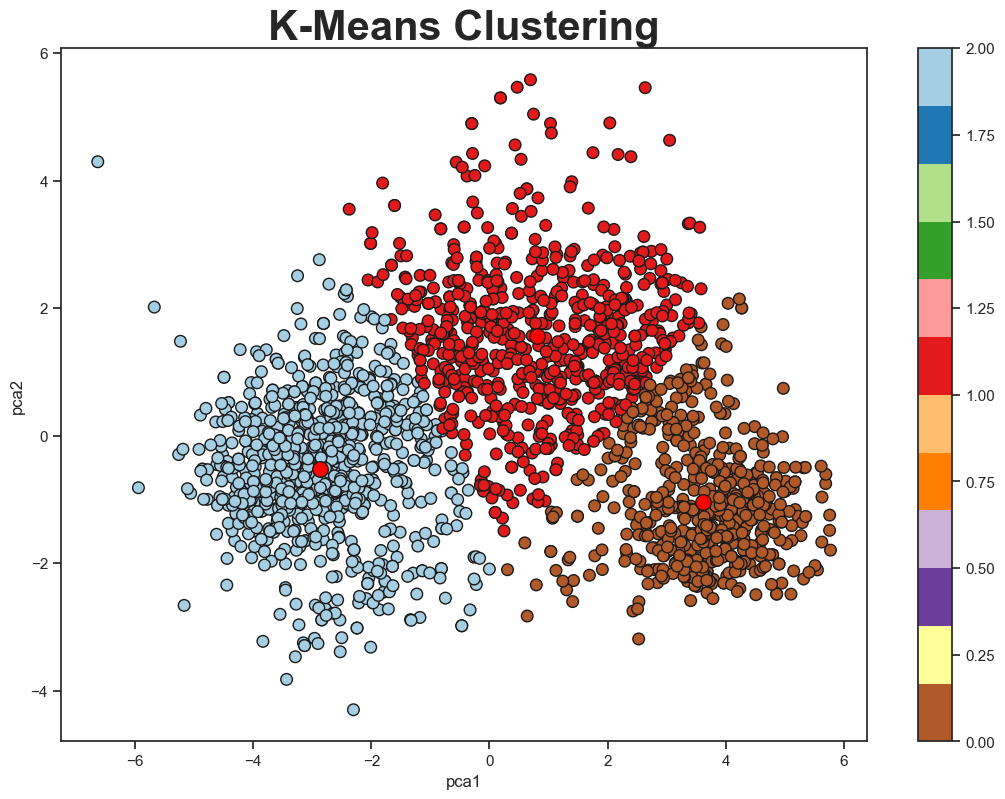

In [35]:
#Plotting the clusters
plt.figure(figsize=(13,9))
plt.title('K-Means Clustering', weight='bold', size=30)
plt.xlabel('pca1')
plt.ylabel('pca2')
scatter = plt.scatter(pcadf['PC1'], pcadf['PC2'], c=model_label, s=70, cmap='Paired_r', ec='k')
plt.colorbar(scatter)
plt.scatter(model_centers[:,0], model_centers[:,1], c='red', marker='.',s=500, ec='k');

# Hierarchical Clustering (Agglomerative)

For n_clusters = 3 The average silhouette_score is : 0.4731726613035477
For n_clusters = 4 The average silhouette_score is : 0.4390868135631675
For n_clusters = 5 The average silhouette_score is : 0.41652907940470996
For n_clusters = 6 The average silhouette_score is : 0.39363131887326636
For n_clusters = 7 The average silhouette_score is : 0.3896956269653036


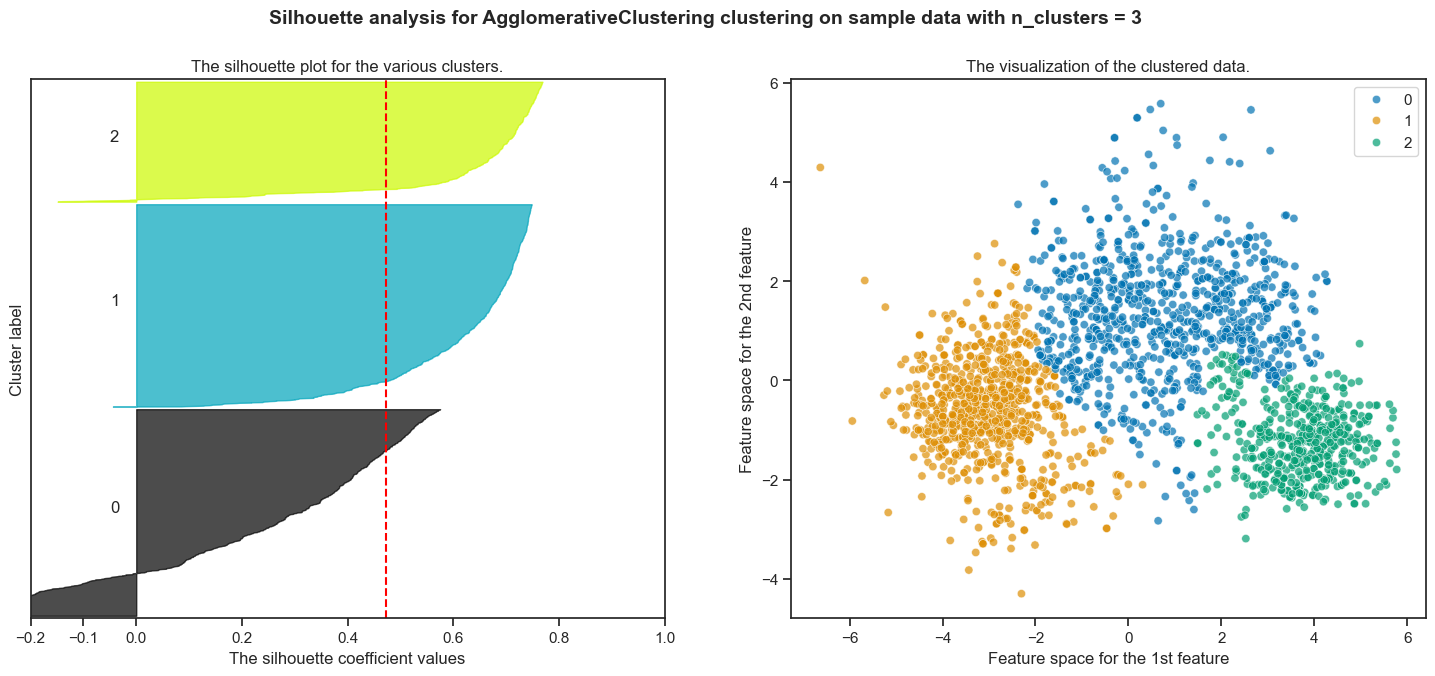

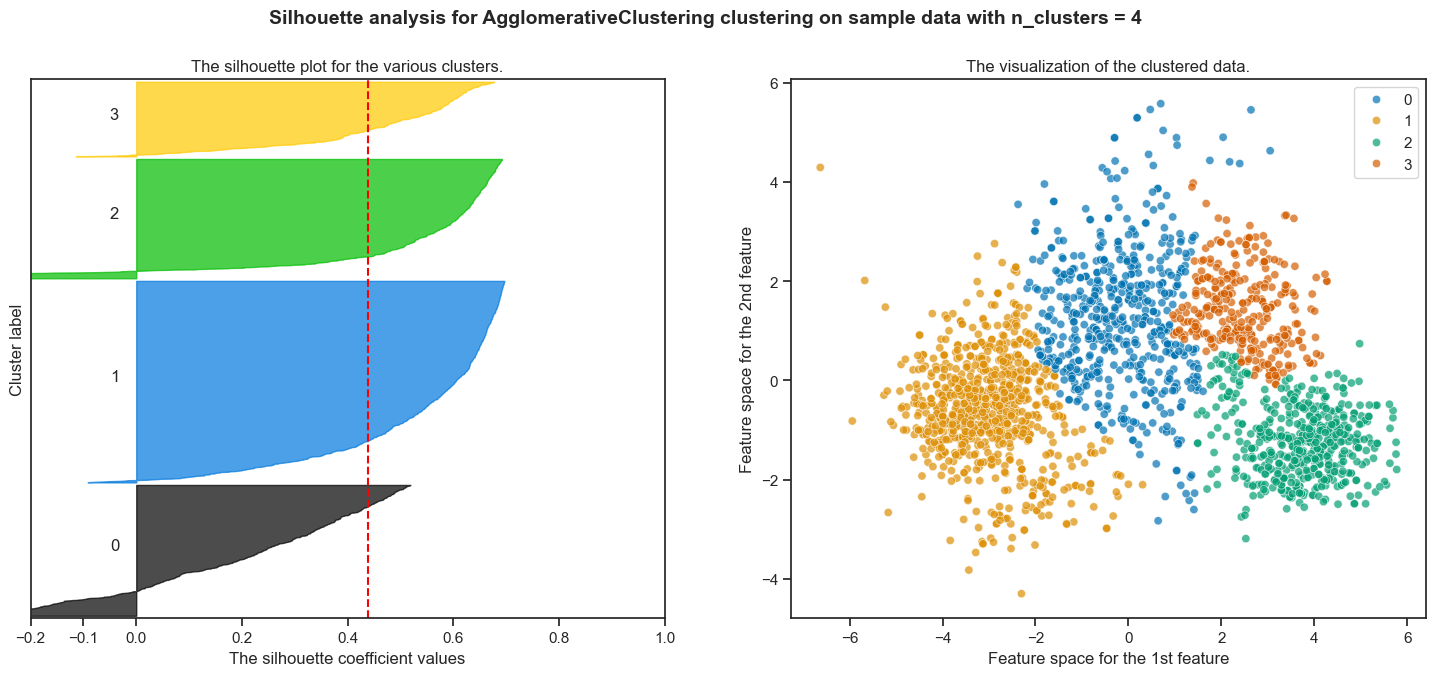

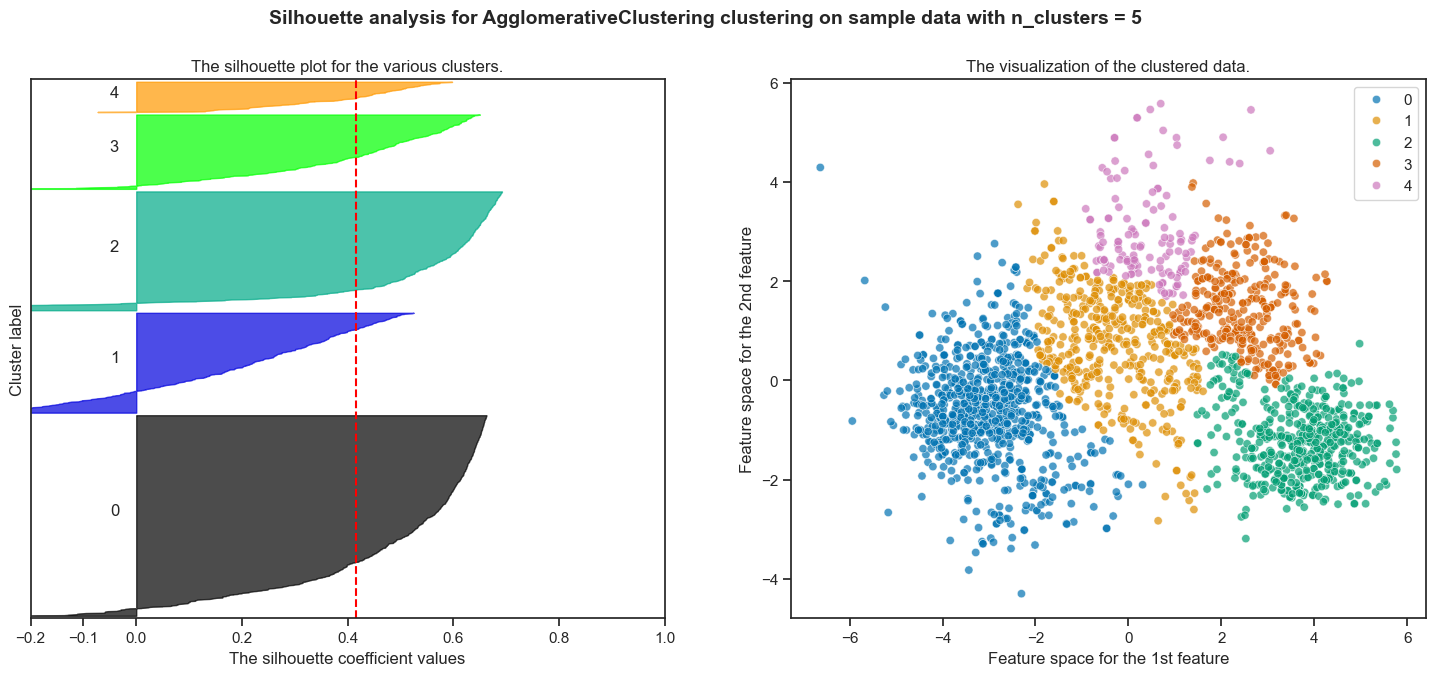

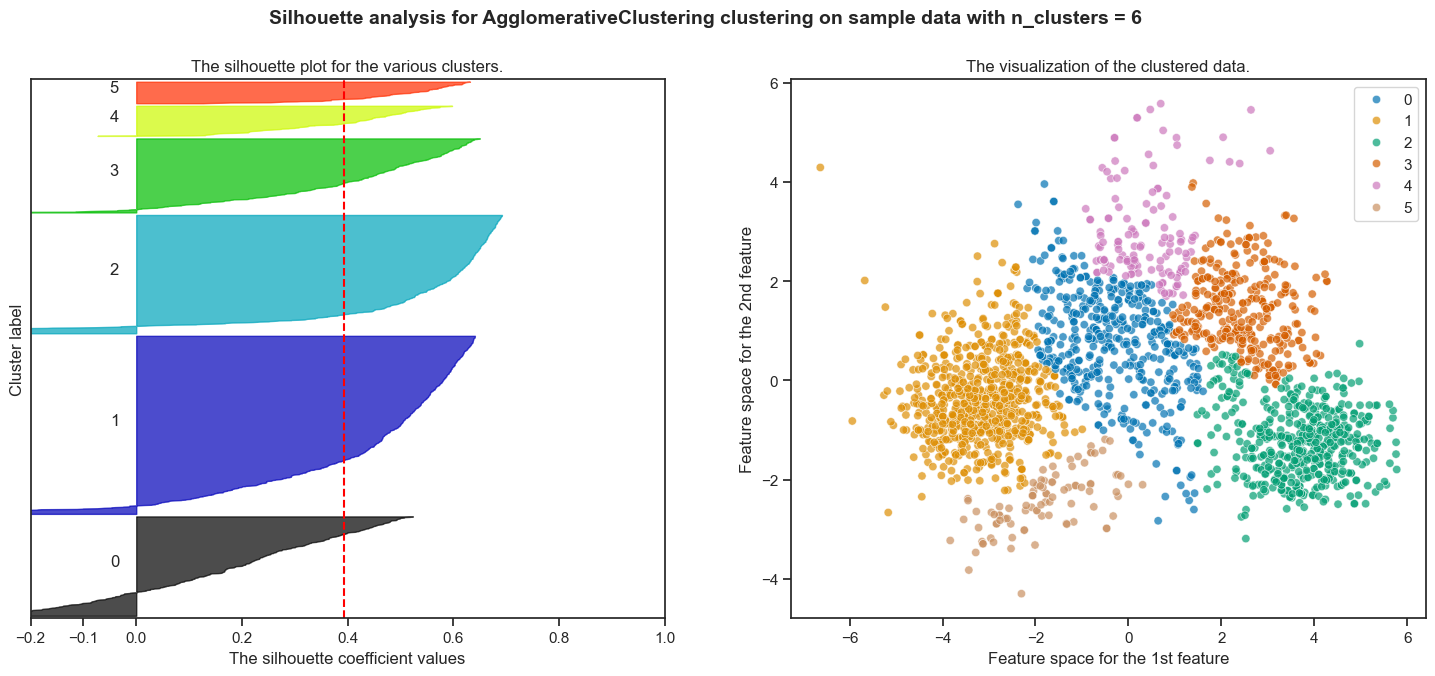

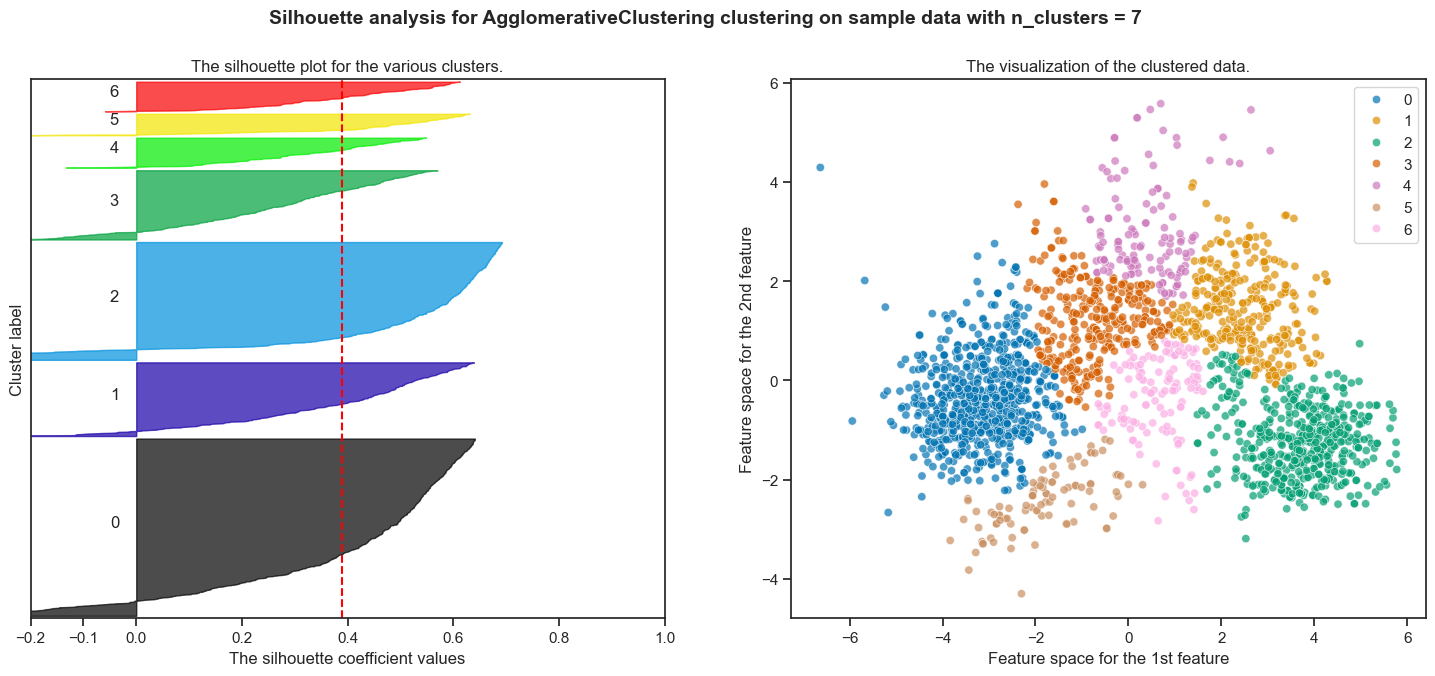

In [36]:
from sklearn.cluster import AgglomerativeClustering
#Plot Score to choose best clusters
silhouette_plot(AgglomerativeClustering,range(3,8),pcadf,reduced)

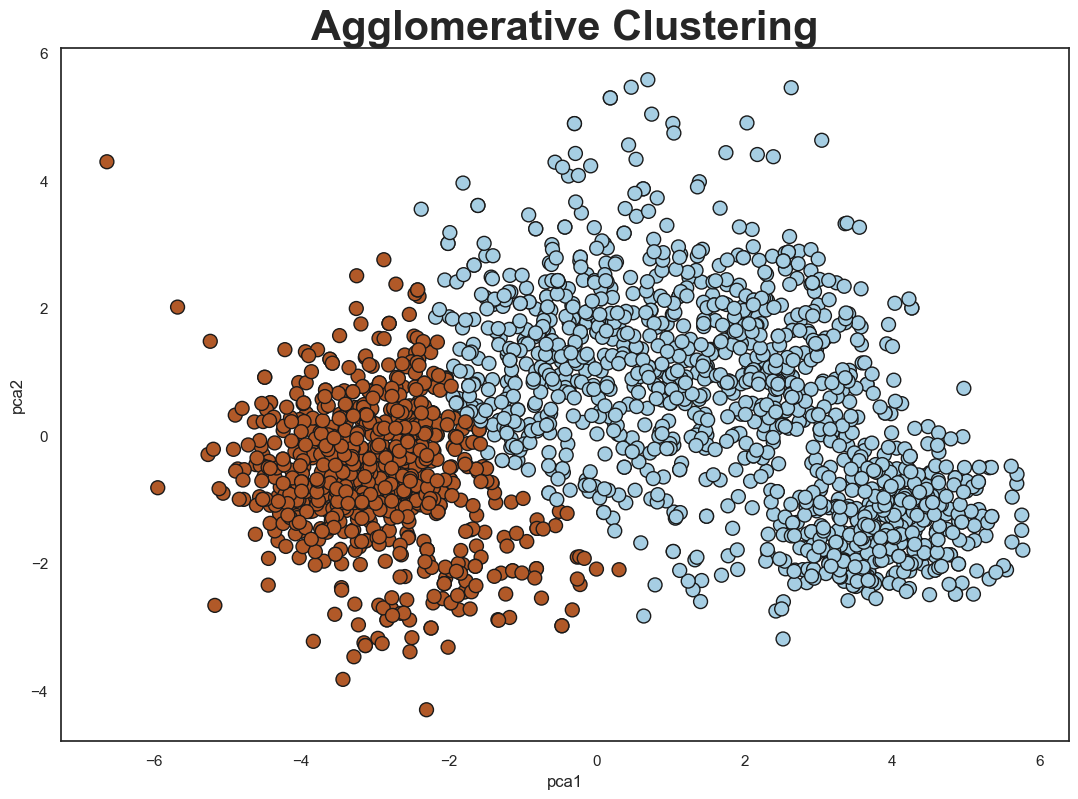

In [38]:
model = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward').fit(reduced)
model_label = model.labels_
plt.figure(figsize=(13,9))

sns.set_style('white')
plt.title('Agglomerative Clustering', weight='bold', size=30)
plt.xlabel('pca1')
plt.ylabel('pca2')
scatter = plt.scatter(pcadf['PC1'], pcadf['PC2'], c=model_label, s=100, cmap='Paired', ec='k')

## Gausian Mixture

For n_clusters = 3 The average silhouette_score is : 0.47682993851941446
For n_clusters = 4 The average silhouette_score is : 0.44572422149131896
For n_clusters = 5 The average silhouette_score is : 0.444068934441556
For n_clusters = 6 The average silhouette_score is : 0.3693958637086956
For n_clusters = 7 The average silhouette_score is : 0.39689857405758766


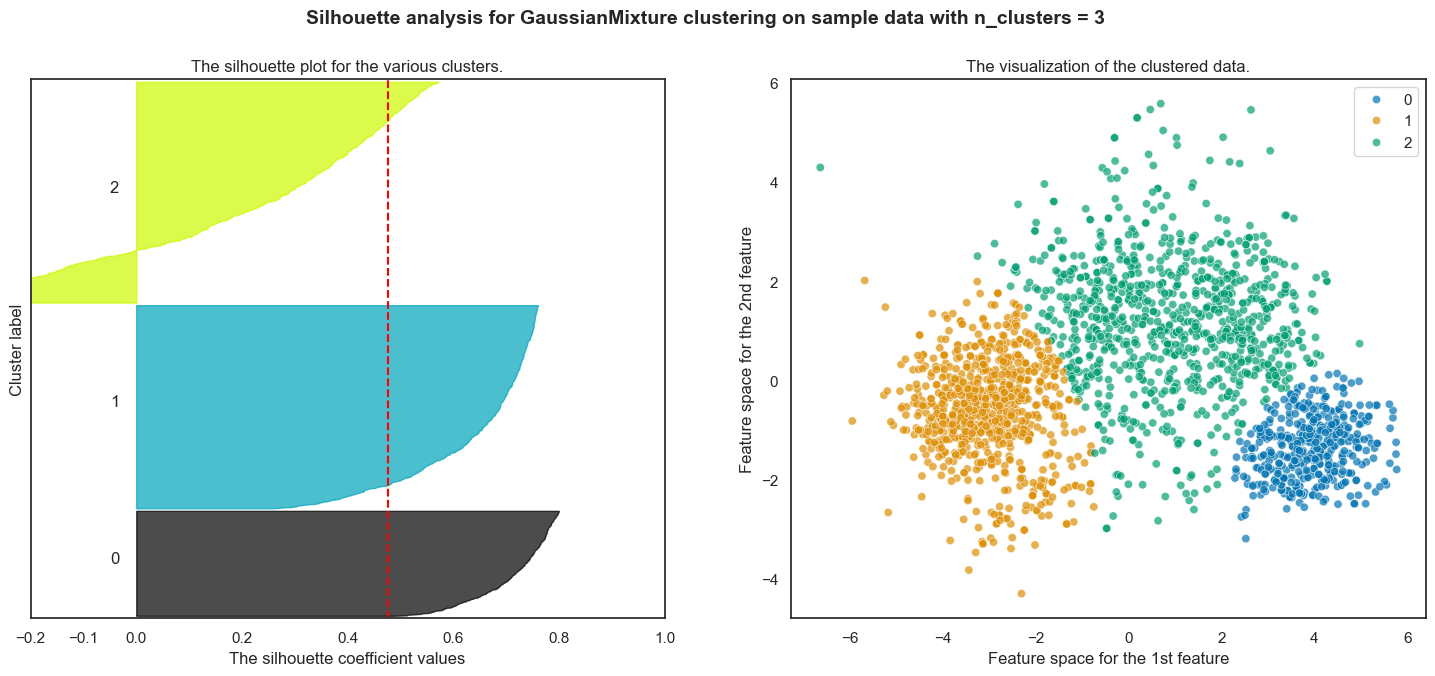

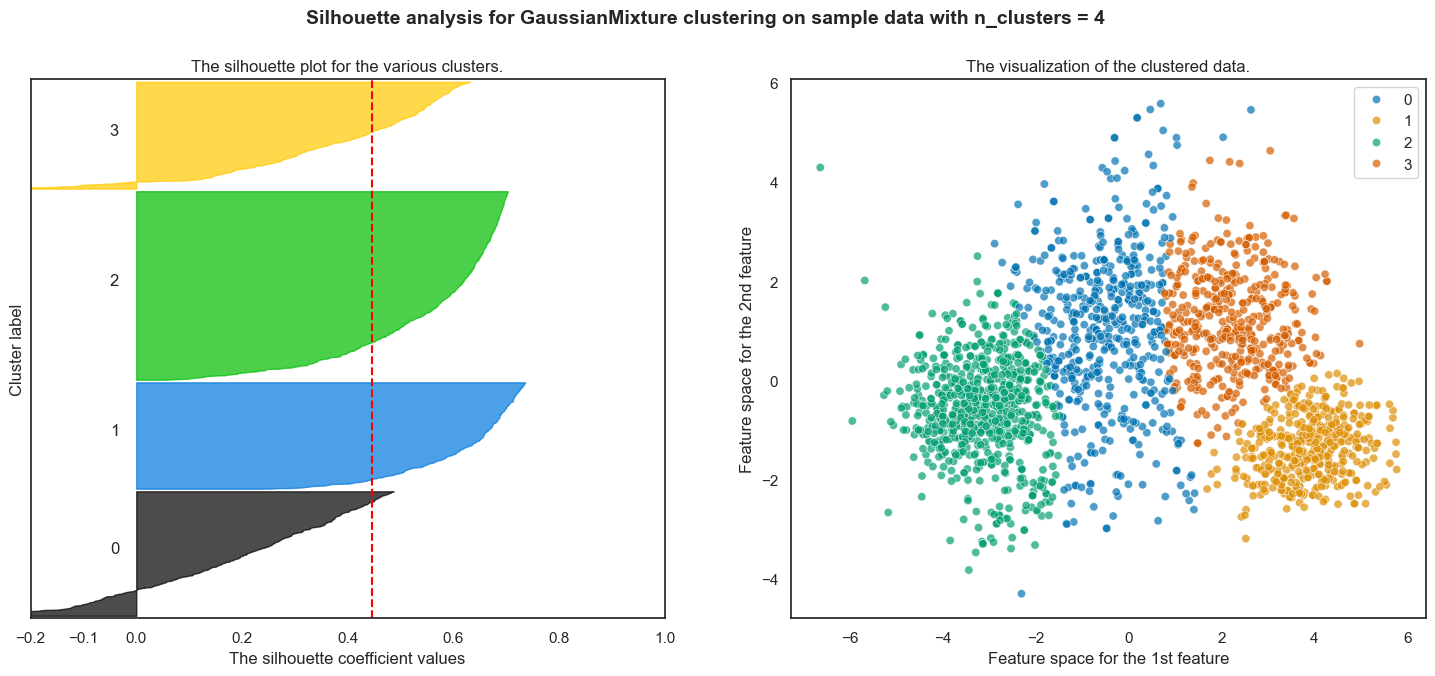

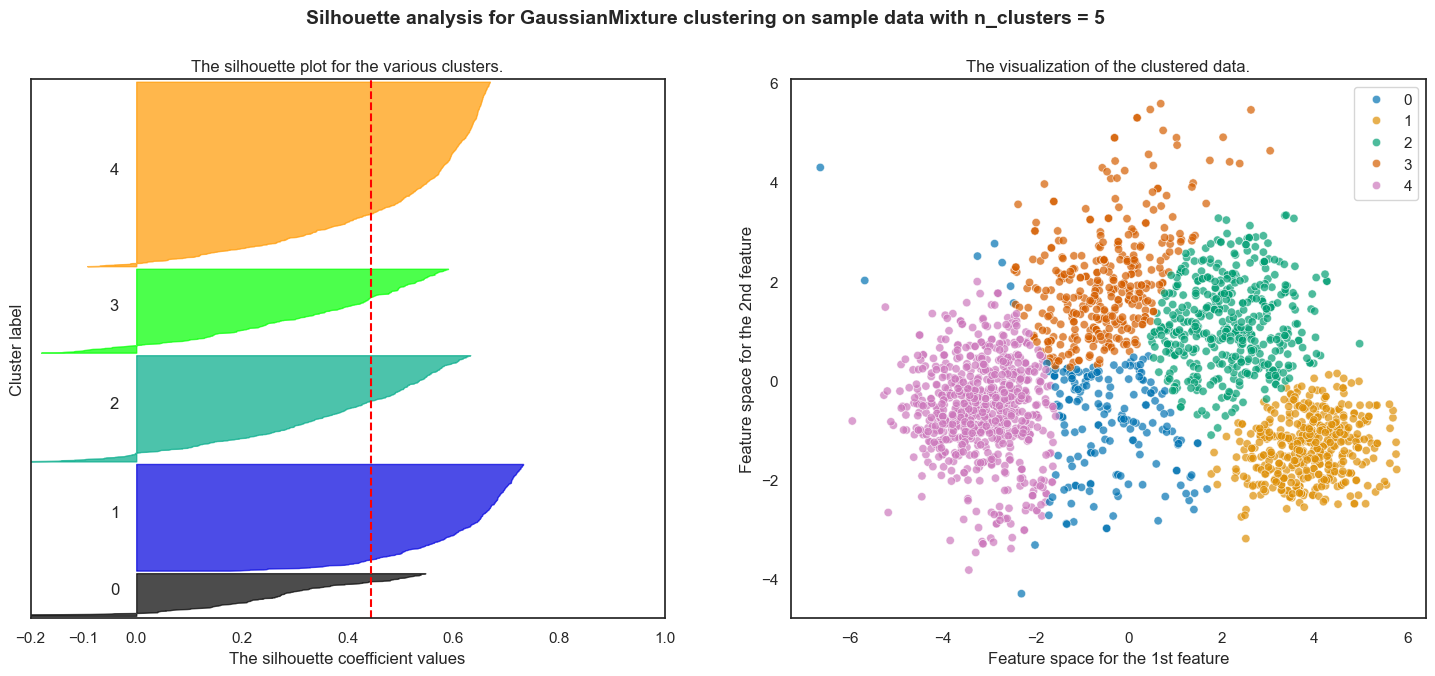

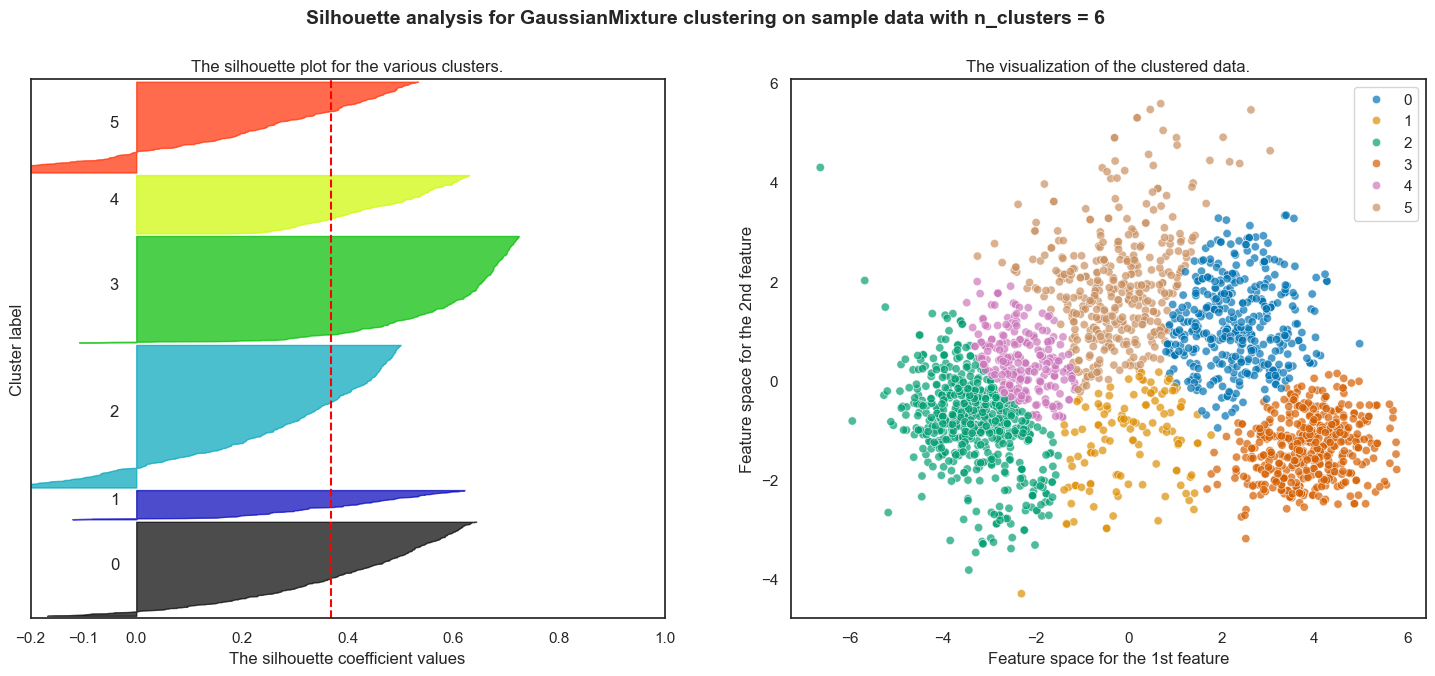

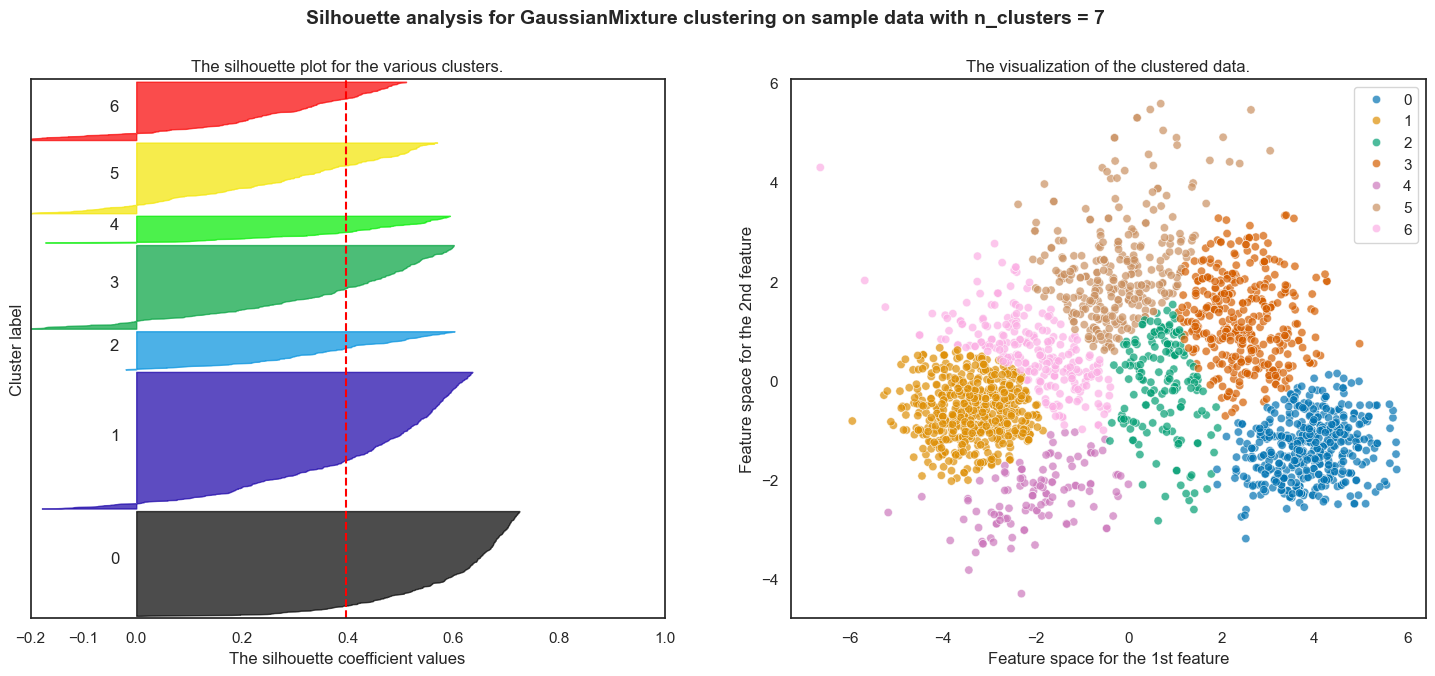

In [39]:
#plotting silhoutte score for Gaussian score
from sklearn.mixture import GaussianMixture
silhouette_plot(GaussianMixture,range(3,8),pcadf,reduced)

for Gaussian Mixture
For n_clusters = 3 The average silhouette_score is : 0.47

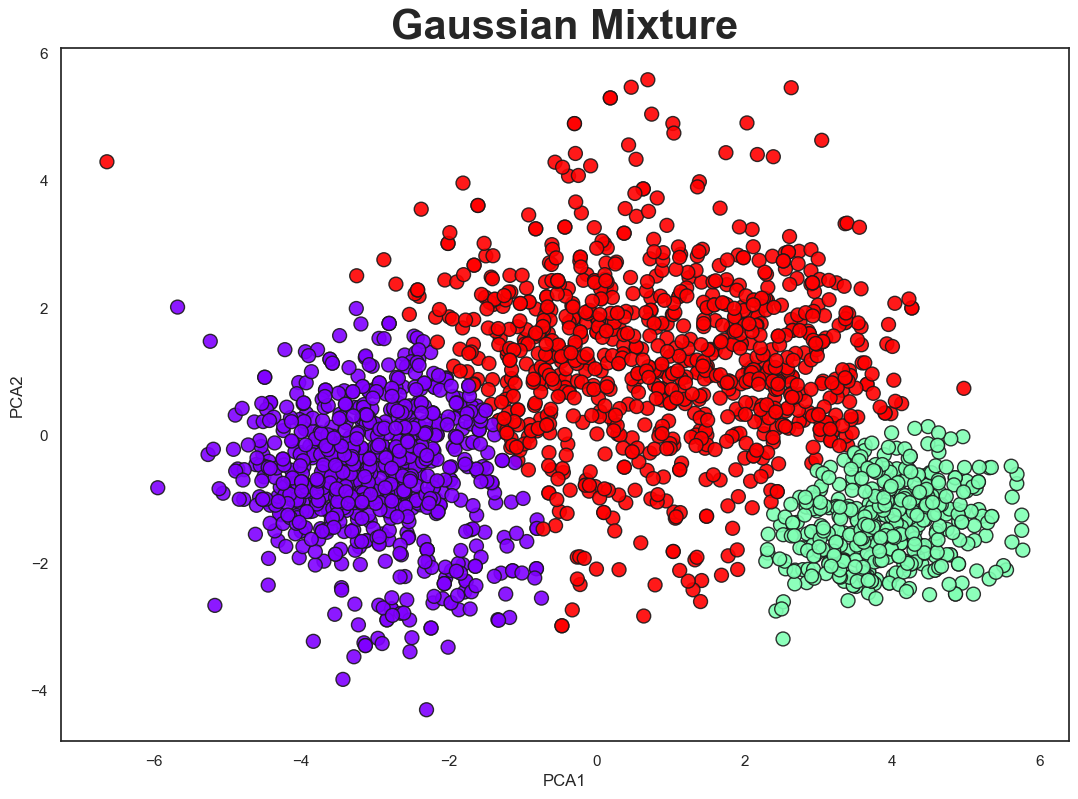

In [40]:
#plotting gaussian mixture with 4 clusters
model = GaussianMixture(n_components=3,random_state=42).fit(reduced)
model_label = model.predict(reduced)
plt.figure(figsize=(13,9))

sns.set_style('white')
plt.title('Gaussian Mixture', weight='bold', size=30)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
scatter = plt.scatter(pcadf['PC1'], pcadf['PC2'], c=model_label, s=100, cmap='rainbow', ec='k', alpha=0.9)

## **DBSCAN Clustering**

- Density-based spatial clustering of applications with noise (DBSCAN) is a data clustering algorithm.
DBSCAN algorithm group points based on distance measurement, usually the Euclidean distance and the minimum number of points. An essential property of this algorithm is that it helps us track down the outliers as the points in low-density regions; hence it is not sensitive to outliers as is the case of K-Means clustering.

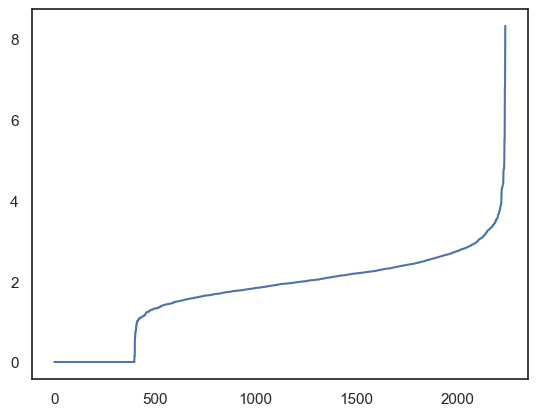

In [41]:
#Find optimal value of epsilon
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

neighbors = NearestNeighbors(n_neighbors=17)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)

distances = np.sort(distances, axis=0)

distances = distances[:,1]
plt.plot(distances)
plt.show()

<Figure size 500x500 with 0 Axes>

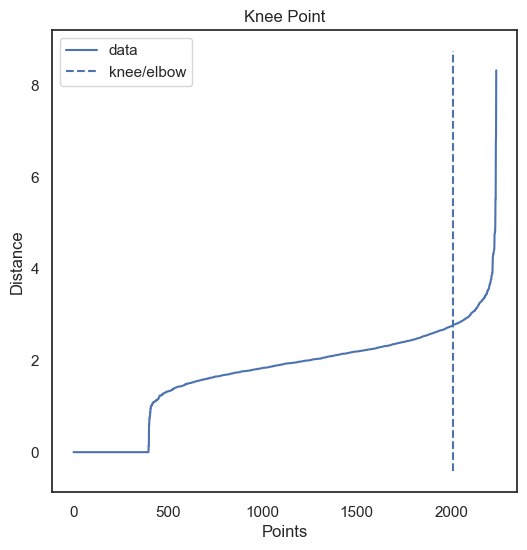

Knee Locator k = 2.756636864835057


In [42]:
# kneedle Algo
from kneed import KneeLocator

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
k= distances[knee.knee]
print('Knee Locator k =', k)

### Plotting using PCA

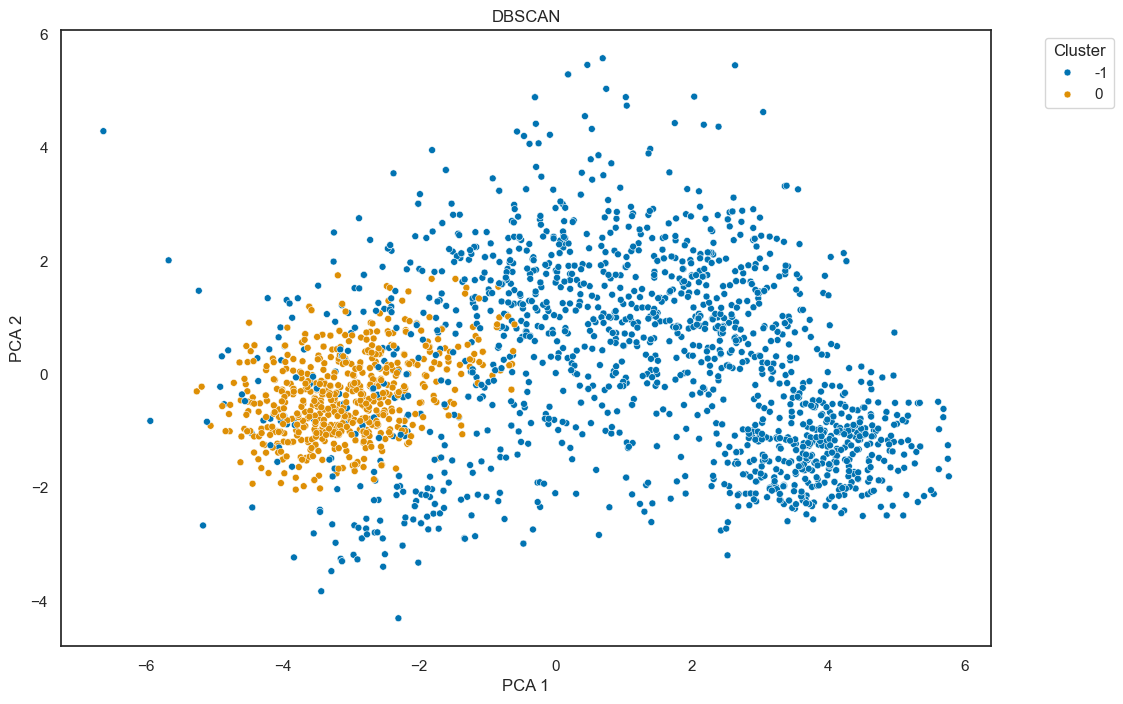

In [44]:
model = DBSCAN(eps=k, min_samples=100).fit(df_scaled)
model_label = model.labels_
plt.figure(figsize=(12,8))

plt.title('DBSCAN')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# convert labels to categorical so seaborn treats them as discrete categories and don't pass cmap
labels = pd.Series(model_label).astype(str)
palette = sns.color_palette("colorblind", n_colors=len(labels.unique()))

scatter = sns.scatterplot(
    x=reduced[:, 0],
    y=reduced[:, 1],
    hue=labels,
    palette=palette,
    s=25,
    legend='full'
)

plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## **DBSCAN didn't perform well in clustering.**
### Its clear that DBSCAN does not work to well when we are dealing with clusters of varying densities or with high dimensional data

## Final Model
- As Kmeans Clustering performed well than rest of the other algorithms, we will go with this

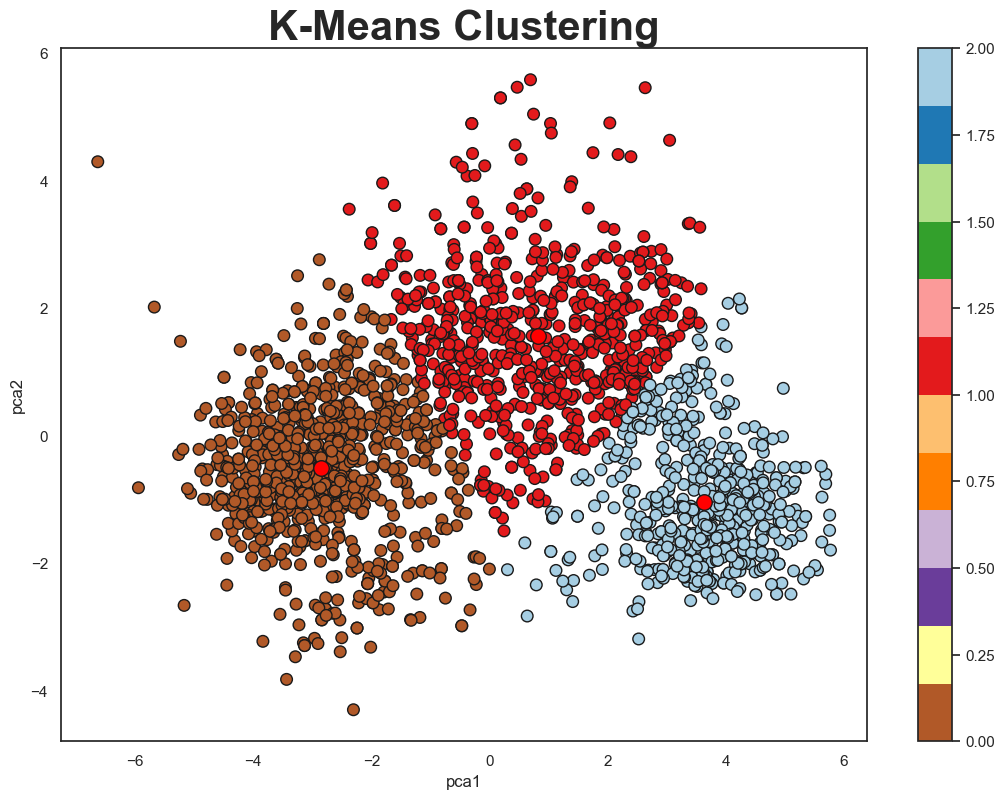

In [45]:
# Fitting the model to reduced data
model = KMeans(n_clusters=3).fit(pcadf)
model_label = model.labels_
model_centers = model.cluster_centers_

#Plotting the clusters
plt.figure(figsize=(13,9))
plt.title('K-Means Clustering', weight='bold', size=30)
plt.xlabel('pca1')
plt.ylabel('pca2')
scatter = plt.scatter(pcadf['PC1'], pcadf['PC2'], c=model_label, s=70, cmap='Paired_r', ec='k')
plt.colorbar(scatter)
plt.scatter(model_centers[:,0], model_centers[:,1], c='red', marker='.',s=500, ec='k');

# Saving the data with cluster column

In [ ]:
#save model labels as new feature
df["cluster"] = model.labels_.astype(int)
df.to_csv("data/clustered_data.csv", index=False)

# **Final report**
- As we got the EDA results, we used that same approaches here also. We extracted out some features to derive valuable meanings from the data and used those in model training.
- The data had outliers and multicollinearity, We created pipelines to handle those things
- We have used PCA to minimize the dimensionality of the data.
- Kmeans Clustering algorithm has performed better then rest of the other clustering algorithms. So we went with it.